# Best mutation on background

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score

sys.path.append("../")
from utils import *
from global_variables import *
from escape_map import *
pgm_path = "PGM/"
sys.path.append(pgm_path + "source/")
sys.path.append(pgm_path + "utilities/")
import utilities, Proteins_utils, sequence_logo, plots_utils
import rbm, RBM_utils

E:\ESCAPE_MAP_DRAFT\PGM\source\numba_utilities.py:1124: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 2, 'F', False, aligned=True), Array(float32, 2, 'A', False, aligned=True))
  dmean_v_dw = np.dot(s1.T, V)
E:\ESCAPE_MAP_DRAFT\PGM\source\numba_utilities.py:961: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 1, 'A', False, aligned=True), Array(float32, 2, 'A', False, aligned=True))
  mean_V = np.dot(weights, V) / sum_weights
C:\Users\maria\AppData\Roaming\Python\Python312\site-packages\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


Loaded 29 KD vectors
Loaded 2 KD vectors
Loaded 671 KD vectors


# Evolution of immune pressure

In [4]:
from collections import defaultdict

def load_voc_fasta(path, dedup=True):
    """
    Read a FASTA file and return a dict: {voc_name: sequence_string}.
    - Header key is the first token after '>' (e.g., '>Alpha something' -> 'Alpha').
    - Sequences are uppercased and whitespace removed.
    - If duplicate headers occur and dedup=True, appends _2, _3, ... to make keys unique.
    """
    voc_to_seq = {}
    counts = defaultdict(int)

    with open(path, "r") as f:
        name = None
        seq_parts = []
        for raw in f:
            line = raw.strip()
            if not line:
                continue
            if line.startswith(">"):
                # commit previous
                if name is not None:
                    seq = "".join(seq_parts).replace(" ", "").upper()
                    voc_to_seq[name] = seq[BEGIN:-END]  # slice to BE region
                # start new
                header = line[1:].strip()
                base = header.split()[0] if header else "UNKNOWN"
                counts[base] += 1
                if counts[base] > 1 and dedup:
                    name = f"{base}_{counts[base]}"
                else:
                    name = base
                seq_parts = []
            else:
                seq_parts.append(line)

        # commit last
        if name is not None:
            seq = "".join(seq_parts).replace(" ", "").upper()
            voc_to_seq[name] = seq[BEGIN:-END]  # slice to BE region

    return voc_to_seq

# --- usage ---
# fasta like:
# >Alpha
# NITNLCPFGEVFNATRFASVY...
# >Beta
# NITNLCPFGEVFNATRFASVY...
voc_to_seq = load_voc_fasta("../seq_data/sequences_vocs.fasta")
print({k: len(v) for k, v in voc_to_seq.items()})
# {'Alpha': 146, 'Beta': 146}  # example lengths

import pandas as pd

voc_to_date = {
    "WT":        pd.Timestamp("2019-12-01"),  # first cluster in Wuhan, Dec 2019
    "Alpha":     pd.Timestamp("2020-09-01"),  # earliest B.1.1.7 genomes Sep 2020 (UK)
    "Beta":      pd.Timestamp("2020-10-01"),  # first detected Oct 2020 (South Africa)
    "Gamma":     pd.Timestamp("2020-12-01"),  # first reported in Manaus in Dec 2020; travelers found Jan 2021
    "Delta":     pd.Timestamp("2020-10-01"),  # first detected 5 Oct 2020 (India)
    "BA.1":      pd.Timestamp("2021-11-01"),  # reported to WHO Nov 24, 2021; earliest specimen Nov 9
    "BA.2":      pd.Timestamp("2021-11-01"),  # first detected mid-Nov 2021
    "BA.5":      pd.Timestamp("2022-02-01"),  # first detected Feb 25, 2022 (South Africa)
    "BA.2.75":   pd.Timestamp("2022-05-01"),  # first detected May 2022 (India)
    "XBB":       pd.Timestamp("2022-08-01"),  # first identified Aug 2022 (India/Asia)
    "BQ.1.1":    pd.Timestamp("2022-07-01"),  # earliest sequences reported July 2022
    "EG":        pd.Timestamp("2023-02-01"),  # EG.5 first reported Feb 17, 2023
    "JN.1":      pd.Timestamp("2023-08-01"),  # first detected Aug 25, 2023
    "NB.1.8.1":  pd.Timestamp("2025-01-01"),  # first detected Jan 2025 (Asia)
}


{'Alpha': 178, 'Beta': 178, 'Gamma': 178, 'Delta': 178, 'BA.1': 178, 'BA.2': 178, 'BA.2.75': 178, 'EG': 178, 'XBB': 178, 'BQ.1.1': 178, 'BA.5': 178, 'WT': 178, 'NB.1.8.1': 178, 'JN.1': 178}


In [5]:
import os
import numpy as np
import pandas as pd

# === config ===
EM_DIR = "../params_by_period_0.03_m1_m8_m7"  # directory containing param_period_YYYY-MM-DD.csv
AA = "ACDEFGHIKLMNPQRSTVWY"                   # canonical amino acids

import pandas as pd

def to_period_start(ts_like) -> pd.Timestamp:
    """
    Snap any date to the start of the 3-month period anchored at 2020-01-01.
    Periods: 2020-01-01, 2020-04-01, 2020-07-01, 2020-10-01, 2021-01-01, ...
    Examples:
      '2020-02-15' -> 2020-01-01
      '2021-11-20' -> 2021-10-01
      '2022-01'    -> 2022-01-01
      '2019-12-10' -> 2020-01-01 (clamped to anchor)
    """
    ts   = pd.to_datetime(ts_like, errors="raise")
    base = pd.Timestamp("2020-01-01")

    # months offset from the anchor
    months_off = (ts.year - base.year) * 12 + (ts.month - base.month)
    k = max(0, months_off // 3)  # clamp to >= 0 so we don't go before 2020-01-01

    start = base + pd.DateOffset(months=3 * k)
    return pd.Timestamp(start.year, start.month, 1)


def gen_single_mutants(seq: str):
    """
    Generate all single mutants of 'seq'.
    Returns: sites (list[int, 1-based]), muts (list[str]), seqs_num (list/array ready for model)
    """
    sites, muts, seqs_str = [], [], []
    L = len(seq)
    for i in range(L):  # 0-based
        wt = seq[i]
        if wt not in AA:
            continue
        for alt in AA:
            if alt == wt:
                continue
            sites.append(i + 1)                     # 1-based site index
            muts.append(f"{wt}{i+1}{alt}")
            seqs_str.append(seq[:i] + alt + seq[i+1:])
    # Convert to model input (numeric) in one pass
    seqs_num = [Proteins_utils.seq2num(s) for s in seqs_str]
    return sites, muts, seqs_num

def escape_score(model, seq_num):
    """score = -model(seq_num) as used elsewhere."""
    return -float(model(seq_num))

def escape_score_batch(model, seqs_num):
    """Vectorized scoring with a safe fallback loop."""
    try:
        # If you have a fast batch scorer available in your env:
        return np.asarray(score_seq_batch(model, seqs_num), dtype=float).ravel()
    except Exception:
        # Fallback: loop; still fine for ~L*19 sequences
        return np.array([-float(model(s)) for s in seqs_num], dtype=float)

def summarize_deltas_for_voc(voc_name: str, seq_str: str, period_date: pd.Timestamp):
    """
    Load model for 'period_date', score all single mutants of 'seq_str',
    compute per-site max Δ and summary stats.
    Returns a dict with summary + a DataFrame of per-site maxima.
    """
    model_path = os.path.join(EM_DIR, f"param_period_{period_date.strftime('%Y-%m-%d')}.csv")
    if not os.path.isfile(model_path):
        raise FileNotFoundError(f"Model CSV not found for {voc_name} at {model_path}")

    # Load model tied to KD_VECTORS (if needed in your loader)
    model = load_escape_map_from_csv(model_path, kd_vectors=KD_VECTORS)

    # Baseline (VOC) score
    wt_num = Proteins_utils.seq2num(seq_str)
    base_score = escape_score(model, wt_num)

    # All single mutants
    sites, muts, seqs_num = gen_single_mutants(seq_str)
    if len(seqs_num) == 0:
        raise RuntimeError(f"No single mutants generated for {voc_name} (sequence length={len(seq_str)})")

    mut_scores = escape_score_batch(model, seqs_num)
    deltas = mut_scores - base_score  # Δ = score(mutant) − score(wt)
    print('deltas', deltas)

    # Per-site maxima
    df_mut = pd.DataFrame({
        "site": sites,
        "mut": muts,
        "delta": deltas
    })
    per_site = df_mut.groupby("site", as_index=False)["delta"].max().rename(columns={"delta": "delta_max"})

    # Summaries
    n_sites_total = per_site.shape[0]
    n_beneficial = int((per_site["delta_max"] > 0).sum())
    frac_beneficial = n_beneficial / n_sites_total if n_sites_total else np.nan

    avg_delta_all = float(np.mean(deltas)) if len(deltas) else np.nan
    avg_delta_site_max = float(per_site["delta_max"].mean()) if n_sites_total else np.nan

    return {
        "VOC": voc_name,
        "Period": period_date,
        "n_sites": n_sites_total,
        "n_beneficial_sites": n_beneficial,
        "frac_beneficial_sites": frac_beneficial,
        "avg_delta_all": avg_delta_all,
        "avg_delta_site_max": avg_delta_site_max,
        "per_site_df": per_site.sort_values("site").reset_index(drop=True),
        "mut_detail_df": df_mut  # optional: full mutants table
    }

# ======== MAIN: iterate over your VOC dictionaries ========
# Expect these to be defined by you:
# voc_to_seq = {"BA.2": "...", "BQ.1": "...", ...}
# voc_to_date = {"BA.2": "2022-01-01", "BQ.1": "2022-07-01", ...}

all_summaries = []
per_voc_site_dfs = {}

for voc, seq_str in voc_to_seq.items():
    if voc not in voc_to_date:
        print(f"[warn] No date for VOC {voc}; skipping.")
        continue
    period = to_period_start(voc_to_date[voc])
    print(f"Processing {voc} @ {period.date()}...")
    res = summarize_deltas_for_voc(voc, seq_str, period)
 

    per_voc_site_dfs[voc] = res.pop("per_site_df")
    # You may also want res.pop("mut_detail_df") if you need the full table
    _ = res.pop("mut_detail_df", None)
    all_summaries.append(res)

voc_summary_df = pd.DataFrame(all_summaries).sort_values(["Period", "VOC"]).reset_index(drop=True)

# Display / print summary
print(voc_summary_df)


Processing Alpha @ 2020-07-01...


C:\Users\maria\AppData\Local\Temp\ipykernel_15384\1591123844.py:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return -float(model(seq_num))
C:\Users\maria\AppData\Local\Temp\ipykernel_15384\1591123844.py:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([-float(model(s)) for s in seqs_num], dtype=float)


deltas [ -5.79370117 -13.27185059  -5.86376953 ...  -7.38342285 -16.06286621
  -6.87182617]
Processing Beta @ 2020-10-01...


C:\Users\maria\AppData\Local\Temp\ipykernel_15384\1591123844.py:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return -float(model(seq_num))
C:\Users\maria\AppData\Local\Temp\ipykernel_15384\1591123844.py:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([-float(model(s)) for s in seqs_num], dtype=float)


deltas [ -5.87072754 -13.38024902  -5.93188477 ...  -7.32373047 -16.04199219
  -6.82507324]
Processing Gamma @ 2020-10-01...


C:\Users\maria\AppData\Local\Temp\ipykernel_15384\1591123844.py:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return -float(model(seq_num))
C:\Users\maria\AppData\Local\Temp\ipykernel_15384\1591123844.py:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([-float(model(s)) for s in seqs_num], dtype=float)


deltas [ -5.79492188 -13.36682129  -5.81665039 ...  -7.37304688 -16.10559082
  -6.88769531]
Processing Delta @ 2020-10-01...


C:\Users\maria\AppData\Local\Temp\ipykernel_15384\1591123844.py:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return -float(model(seq_num))
C:\Users\maria\AppData\Local\Temp\ipykernel_15384\1591123844.py:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([-float(model(s)) for s in seqs_num], dtype=float)


deltas [ -5.94030762 -13.46765137  -6.00524902 ...  -7.52514648 -16.2701416
  -7.0177002 ]
Processing BA.1 @ 2021-10-01...


C:\Users\maria\AppData\Local\Temp\ipykernel_15384\1591123844.py:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return -float(model(seq_num))
C:\Users\maria\AppData\Local\Temp\ipykernel_15384\1591123844.py:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([-float(model(s)) for s in seqs_num], dtype=float)


deltas [ -5.72973633 -12.59265137  -5.98376465 ...  -6.73181152 -15.10742188
  -6.1817627 ]
Processing BA.2 @ 2021-10-01...


C:\Users\maria\AppData\Local\Temp\ipykernel_15384\1591123844.py:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return -float(model(seq_num))
C:\Users\maria\AppData\Local\Temp\ipykernel_15384\1591123844.py:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([-float(model(s)) for s in seqs_num], dtype=float)


deltas [ -5.53234863 -12.54943848  -5.71044922 ...  -6.68200684 -14.98803711
  -6.11474609]
Processing BA.2.75 @ 2022-04-01...


C:\Users\maria\AppData\Local\Temp\ipykernel_15384\1591123844.py:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return -float(model(seq_num))
C:\Users\maria\AppData\Local\Temp\ipykernel_15384\1591123844.py:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([-float(model(s)) for s in seqs_num], dtype=float)


deltas [ -4.93334961 -11.23364258  -5.08325195 ...  -5.97290039 -13.36621094
  -5.68237305]
Processing EG @ 2023-01-01...


C:\Users\maria\AppData\Local\Temp\ipykernel_15384\1591123844.py:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return -float(model(seq_num))
C:\Users\maria\AppData\Local\Temp\ipykernel_15384\1591123844.py:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([-float(model(s)) for s in seqs_num], dtype=float)


deltas [ -5.22619629 -12.12133789  -5.32946777 ...  -6.4654541  -14.39074707
  -6.09692383]
Processing XBB @ 2022-07-01...


C:\Users\maria\AppData\Local\Temp\ipykernel_15384\1591123844.py:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return -float(model(seq_num))
C:\Users\maria\AppData\Local\Temp\ipykernel_15384\1591123844.py:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([-float(model(s)) for s in seqs_num], dtype=float)


deltas [ -4.81750488 -10.96569824  -4.98297119 ...  -5.7644043  -12.88647461
  -5.45721436]
Processing BQ.1.1 @ 2022-07-01...


C:\Users\maria\AppData\Local\Temp\ipykernel_15384\1591123844.py:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return -float(model(seq_num))
C:\Users\maria\AppData\Local\Temp\ipykernel_15384\1591123844.py:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([-float(model(s)) for s in seqs_num], dtype=float)


deltas [ -4.87121582 -11.0322876   -5.00646973 ...  -5.81396484 -12.92346191
  -5.58459473]
Processing BA.5 @ 2022-01-01...


C:\Users\maria\AppData\Local\Temp\ipykernel_15384\1591123844.py:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return -float(model(seq_num))
C:\Users\maria\AppData\Local\Temp\ipykernel_15384\1591123844.py:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([-float(model(s)) for s in seqs_num], dtype=float)


deltas [ -5.37268066 -12.18786621  -5.54492188 ...  -6.43688965 -14.25305176
  -5.98010254]
Processing WT @ 2020-01-01...


C:\Users\maria\AppData\Local\Temp\ipykernel_15384\1591123844.py:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return -float(model(seq_num))
C:\Users\maria\AppData\Local\Temp\ipykernel_15384\1591123844.py:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([-float(model(s)) for s in seqs_num], dtype=float)


deltas [ -6.02832031 -13.64013672  -6.16687012 ...  -7.56542969 -16.48901367
  -7.03295898]
Processing NB.1.8.1 @ 2025-01-01...


C:\Users\maria\AppData\Local\Temp\ipykernel_15384\1591123844.py:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return -float(model(seq_num))
C:\Users\maria\AppData\Local\Temp\ipykernel_15384\1591123844.py:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([-float(model(s)) for s in seqs_num], dtype=float)


deltas [ -4.79388428 -10.6651001   -5.00695801 ...  -5.64251709 -12.65570068
  -5.36120605]
Processing JN.1 @ 2023-07-01...


C:\Users\maria\AppData\Local\Temp\ipykernel_15384\1591123844.py:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return -float(model(seq_num))
C:\Users\maria\AppData\Local\Temp\ipykernel_15384\1591123844.py:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([-float(model(s)) for s in seqs_num], dtype=float)


deltas [ -5.08532715 -11.38964844  -5.26062012 ...  -5.9822998  -13.38342285
  -5.73498535]
         VOC     Period  n_sites  n_beneficial_sites  frac_beneficial_sites  \
0         WT 2020-01-01      178                  33               0.185393   
1      Alpha 2020-07-01      178                  34               0.191011   
2       Beta 2020-10-01      178                  34               0.191011   
3      Delta 2020-10-01      178                  38               0.213483   
4      Gamma 2020-10-01      178                  36               0.202247   
5       BA.1 2021-10-01      178                  41               0.230337   
6       BA.2 2021-10-01      178                  39               0.219101   
7       BA.5 2022-01-01      178                  45               0.252809   
8    BA.2.75 2022-04-01      178                  42               0.235955   
9     BQ.1.1 2022-07-01      178                  42               0.235955   
10       XBB 2022-07-01      178       

C:\Users\maria\AppData\Local\Temp\ipykernel_15384\3424112777.py:45: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


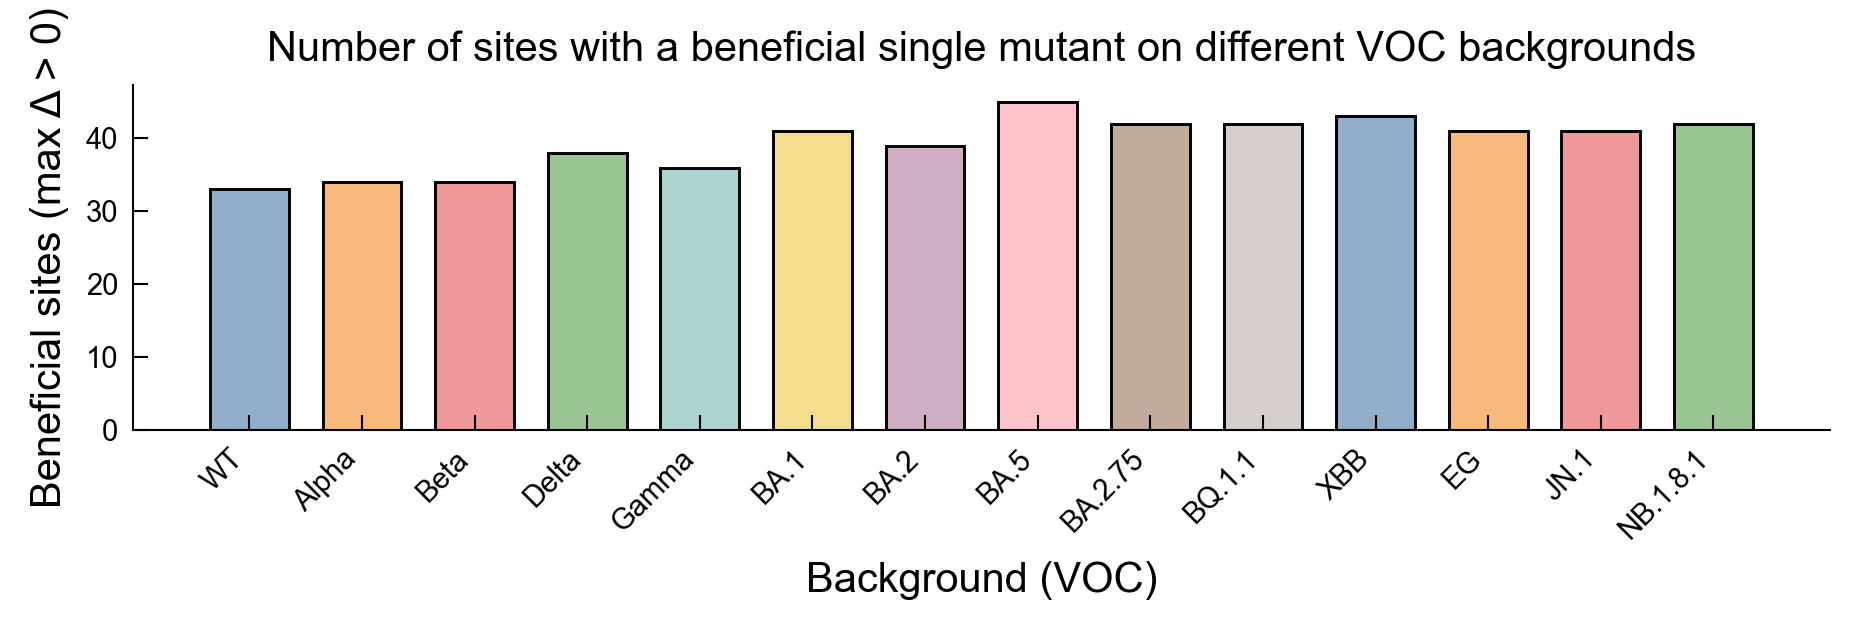

C:\Users\maria\AppData\Local\Temp\ipykernel_15384\3424112777.py:62: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


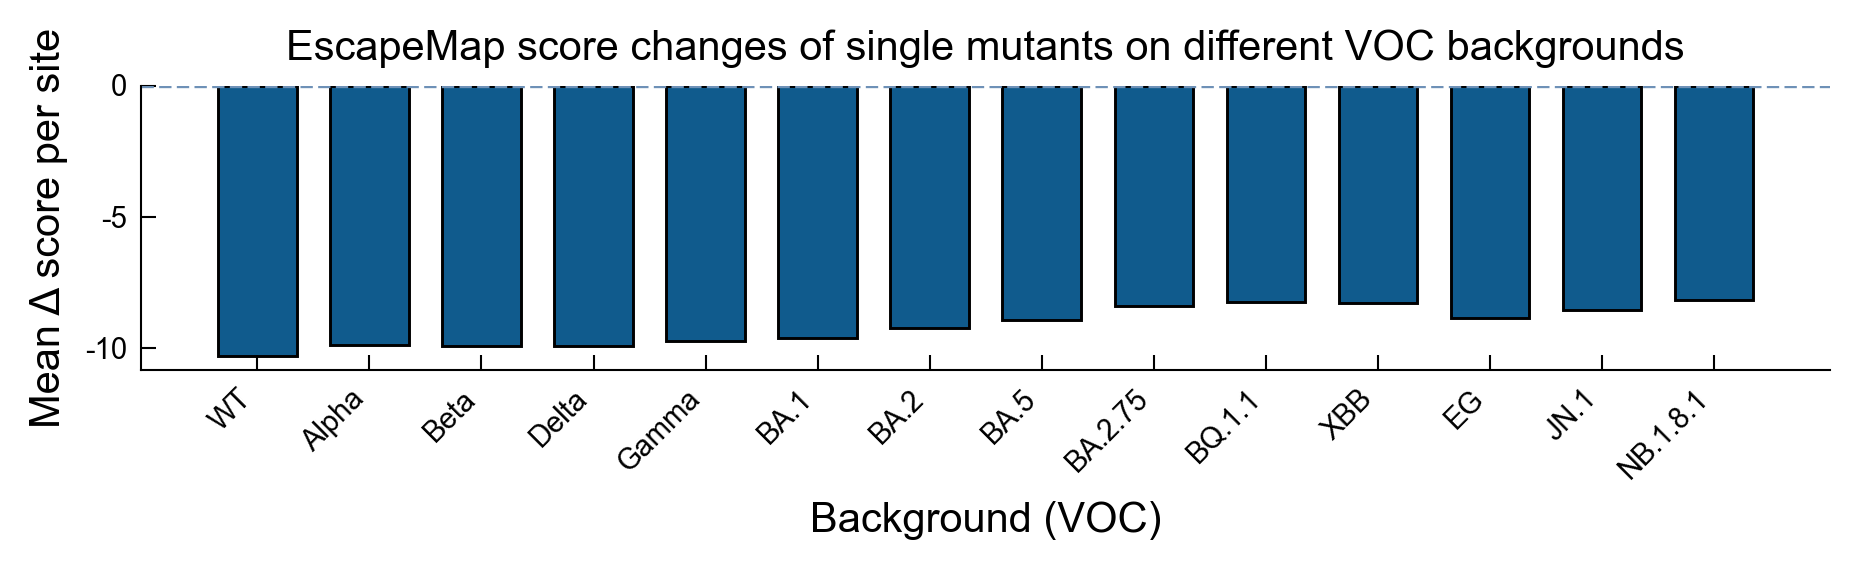

In [6]:
# === Nature-style plots: n_beneficial_sites and avg_delta_all vs VOC (ordered by date) ===
import numpy as np
import matplotlib.pyplot as plt

# 0) Safety check + ordering by date
need = {"VOC","Period","n_beneficial_sites","avg_delta_all"}
missing = need - set(voc_summary_df.columns)
if missing:
    raise ValueError(f"voc_summary_df missing columns: {missing}")

plot_df = (
    voc_summary_df
    .sort_values(["Period","VOC"])
    .reset_index(drop=True)
)

labels = plot_df["VOC"].tolist()
x = np.arange(len(labels))
from plot_utils import nature_rc, get_lightened_cycle
# 1) Apply Nature rc
nature_rc()

# 2) Colors (lightened cycle)
try:
    colors = get_lightened_cycle(len(labels), amount=0.25)
except Exception:
    colors = None  # let Matplotlib choose

# 3) Figure sizes tuned to #labels
w = max(3.35, 0.45 * len(labels))  # widen with more VOCs

# ---- Plot A: number of beneficial sites ----
fig, ax = plt.subplots(figsize=(w, 2.2))
ax.bar(x, plot_df["n_beneficial_sites"].to_numpy(),
       color=colors, edgecolor="black", linewidth=0.7, width=0.7)

ax.set_ylabel("Beneficial sites (max Δ > 0)", fontsize=10)
ax.set_xlabel("Background (VOC)", fontsize=10)
#title
ax.set_title("Number of sites with a beneficial single mutant on different VOC backgrounds", fontsize=10)
ax.set_xticks(x, labels, rotation=45, ha="right")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

# ---- Plot B: average Δ score over all single mutants ----
fig, ax = plt.subplots(figsize=(w, 2.0))
ax.bar(x, plot_df["avg_delta_all"].to_numpy(),
       color="#105B8D", edgecolor="black", linewidth=0.7, width=0.7)

ax.set_ylabel("Mean Δ score per site", fontsize=10)
ax.set_xlabel("Background (VOC)", fontsize=10)
#title
ax.set_title("EscapeMap score changes of single mutants on different VOC backgrounds", fontsize=10)
ax.set_xticks(x, labels, rotation=45, ha="right")
ax.axhline(0.0, linestyle="--", linewidth=0.8)  # reference line at zero
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()
